In [1]:
import pandas as pd
from datasets import Dataset, DatasetDict
from utils import import_dataset
from tqdm.notebook import tqdm
import random
from numpy import mean, std

In [2]:
data = import_dataset()

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 2476
    })
    eval: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 309
    })
    test: Dataset({
        features: ['title', 'genre', 'text', 'labels'],
        num_rows: 310
    })
})

https://huggingface.co/docs/transformers/tasks/sequence_classification

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
accuracy = evaluate.load("accuracy")
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
os.environ["WANDB_DISABLED"] = "true"

In [5]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [6]:
id2label = {0: "dialogues", 
            1: "dissertation",
            2: "enquiry",
            3: "essay",
            4: "history",
            5: "political discourses",
            6: "treatise"}

label2id = {val : key for key, val in id2label.items()}

In [8]:
def run_model(model_name, dataset, n_epochs, print_examples=False, matrix=True):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, max_length=512)
    
    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label), 
        id2label=id2label, 
        label2id=label2id)
    
    training_args = TrainingArguments(
        output_dir=f"models/{model_name}-finetuned",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=n_epochs,
        weight_decay=0.01,
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["eval"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    
    ## testing
    
    correct = 0
    samples = 0

    y_test = []
    predictions = []


    for line in tokenized_dataset['test']:
        text = line['text']
        label = line['labels']
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
    #     model.config.id2label[predicted_class_id]
        if label == predicted_class_id:
            correct += 1
        samples += 1

        y_test.append(label)
        predictions.append(predicted_class_id)

        if print_examples and label == 4 and predicted_class_id != 4:
            print(f'history predicted as {id2label[predicted_class_id]}')
            print(line['title'])
            print(text)
            print()
            
    print('TEST ACCURACY: ', correct/samples)
    
    classes = ['dialogues', 'dissertation', 'enquiry', 'essay', 'history', 'political discourses', 'treatise']
    
    if matrix: 
        fig, ax = plt.subplots(figsize=(10, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)
        ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6], classes, rotation=60)
        ax.yaxis.set_ticks([0, 1, 2, 3, 4, 5, 6], classes)
        plt.title(model_name)
    
    return correct/samples

In [84]:
def run_many(model, n, n_epochs):
    accuracy_scores = []
    for seed in tqdm([i for i in range(n)]): 
        data = import_dataset(seed)
        accuracy_ = run_model(model, data, n_epochs=n_epochs, matrix=False)
        accuracy_scores.append(accuracy_)

    print('Mean accuracy: ', mean(accuracy_scores))
    print('Standard deviation for accuracy: ', std(accuracy_scores))

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.402300,1.020136,0.634304
2,0.885200,0.819149,0.702265
3,0.641400,0.755678,0.734628
4,0.482100,0.747376,0.744337
5,0.385800,0.744306,0.737864


history predicted as essay
XXIII
Those who cast their eye on the general revolutions of society, will find, that, as almost all improvements of the human mind had reached nearly to their state of perfection about the age of Augustus, there was a sensible decline from that point or period; and man thenceforth relapsed gradually into ignorance and barbarism. The unlimited extent of the Roman empire, and the consequent despotism of its monarchs, extinguished all emulation, debased the generous spirits of men, and depressed that noble flame, by which all the refined arts must be cherished and enlivened. The military government, which soon succeeded, rendered even the lives and properties of men insecure and precarious; and proved destructive to those vulgar and more necessary arts of agriculture, manufactures, and commerce; and in the end, to the military art and genius itself, by which alone the immense fabric of the empire could be supported. The irruption of the barbarous nations, which

0.7612903225806451

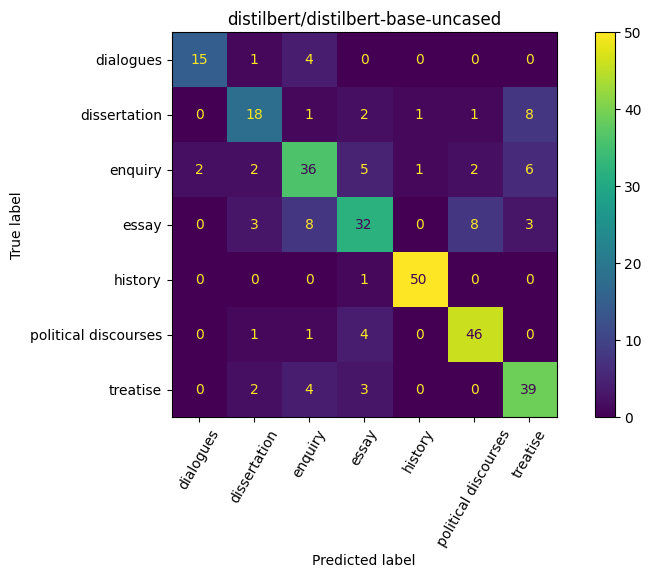

In [88]:
run_model('distilbert/distilbert-base-uncased', data, n_epochs=5, print_examples=True)

In [85]:
run_many('distilbert/distilbert-base-uncased', n=15, n_epochs=5)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.395600,1.025072,0.660194
2,0.879000,0.800871,0.705502
3,0.633600,0.688187,0.744337
4,0.473100,0.685982,0.747573
5,0.384100,0.637106,0.776699


TEST ACCURACY:  0.832258064516129


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.416600,1.154580,0.521036
2,0.905800,0.867251,0.663430
3,0.660600,0.769817,0.708738
4,0.483900,0.725743,0.750809
5,0.382000,0.710798,0.760518


TEST ACCURACY:  0.7322580645161291


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.397700,0.994872,0.631068
2,0.900000,0.854395,0.663430
3,0.666700,0.803162,0.699029
4,0.493100,0.731185,0.734628
5,0.400000,0.710820,0.741100


TEST ACCURACY:  0.7645161290322581


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.414200,1.095177,0.601942
2,0.922600,0.860729,0.695793
3,0.677700,0.730570,0.737864
4,0.506000,0.682653,0.776699
5,0.402700,0.683046,0.760518


TEST ACCURACY:  0.7419354838709677


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.376900,0.999907,0.631068
2,0.900000,0.831191,0.689320
3,0.686500,0.697621,0.737864
4,0.533500,0.718342,0.724919
5,0.438400,0.659623,0.757282


TEST ACCURACY:  0.7612903225806451


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.394400,1.091703,0.585761
2,0.897900,0.833814,0.673139
3,0.662700,0.773638,0.724919
4,0.511300,0.688181,0.773463
5,0.413700,0.666141,0.799353


TEST ACCURACY:  0.7677419354838709


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.408800,1.100683,0.605178
2,0.899700,0.830511,0.689320
3,0.650600,0.768782,0.711974
4,0.491300,0.778564,0.702265
5,0.395500,0.766598,0.731392


TEST ACCURACY:  0.7709677419354839


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.384500,1.110285,0.563107
2,0.875300,0.920426,0.621359
3,0.667200,0.817652,0.679612
4,0.505700,0.729642,0.744337
5,0.411800,0.718052,0.754045


TEST ACCURACY:  0.7258064516129032


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.400400,1.048163,0.614887
2,0.915600,0.828957,0.686084
3,0.692500,0.703175,0.760518
4,0.524200,0.661804,0.763754
5,0.422500,0.614412,0.779935


TEST ACCURACY:  0.7483870967741936


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.406200,1.052285,0.631068
2,0.912500,0.855602,0.705502
3,0.678200,0.795132,0.711974
4,0.525900,0.764296,0.728155
5,0.432500,0.755896,0.734628


TEST ACCURACY:  0.7322580645161291


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.385200,1.022274,0.601942
2,0.898600,0.791994,0.708738
3,0.667300,0.698358,0.737864
4,0.518500,0.621235,0.783172
5,0.418800,0.604202,0.779935


TEST ACCURACY:  0.7741935483870968


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.405700,1.013532,0.618123
2,0.914400,0.802024,0.679612
3,0.680300,0.673740,0.757282
4,0.514100,0.622983,0.754045
5,0.410000,0.602210,0.773463


TEST ACCURACY:  0.7838709677419354


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.401500,1.031809,0.605178
2,0.904700,0.851922,0.644013
3,0.681000,0.748088,0.699029
4,0.516500,0.705585,0.715210
5,0.418500,0.695125,0.702265


TEST ACCURACY:  0.8


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.429900,1.082953,0.618123
2,0.921500,0.892594,0.666667
3,0.667100,0.770820,0.715210
4,0.493700,0.744073,0.718447
5,0.397700,0.728266,0.734628


TEST ACCURACY:  0.7451612903225806


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.417300,1.028223,0.624595
2,0.927000,0.861031,0.640777
3,0.703000,0.765743,0.702265
4,0.531500,0.735908,0.724919
5,0.432300,0.720825,0.724919


TEST ACCURACY:  0.7516129032258064
Mean accuracy:  0.7621505376344085
Standard deviation for accuracy:  0.02730759428705372


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.158200,0.823576,0.737864
2,0.607100,0.568967,0.799353
3,0.340800,0.495137,0.822006
4,0.186800,0.542336,0.844660
5,0.093100,0.511752,0.847896
6,0.040900,0.664313,0.841424
7,0.018800,0.689086,0.844660
8,0.008900,0.665244,0.857605
9,0.007400,0.681109,0.860841
10,0.006300,0.686742,0.860841


TEST ACCURACY:  0.8064516129032258


0.8064516129032258

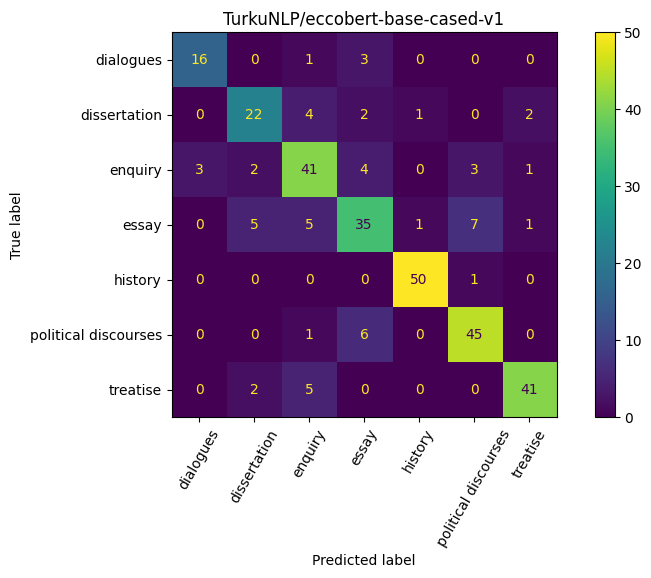

In [87]:
run_model('TurkuNLP/eccobert-base-cased-v1', data, n_epochs=10)

In [89]:
run_many('TurkuNLP/eccobert-base-cased-v1', n=15, n_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.165600,0.746517,0.757282
2,0.609100,0.544452,0.812298
3,0.353300,0.492910,0.815534
4,0.187100,0.466235,0.847896
5,0.078200,0.568070,0.844660
6,0.031600,0.643321,0.834951
7,0.013400,0.597312,0.825243
8,0.005900,0.641803,0.847896
9,0.004700,0.624854,0.851133
10,0.003700,0.626689,0.834951


TEST ACCURACY:  0.8580645161290322


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.175900,0.867847,0.679612
2,0.564800,0.543349,0.828479
3,0.313900,0.559647,0.815534
4,0.166100,0.644786,0.818770
5,0.089100,0.793129,0.805825
6,0.041900,0.829231,0.825243
7,0.019700,0.745083,0.828479
8,0.007900,0.827711,0.822006
9,0.006100,0.818847,0.841424
10,0.004300,0.833184,0.844660


TEST ACCURACY:  0.8354838709677419


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.199700,0.710513,0.779935
2,0.614400,0.569664,0.809061
3,0.335300,0.545086,0.812298
4,0.192800,0.546983,0.825243
5,0.101700,0.562073,0.844660
6,0.045600,0.628441,0.847896
7,0.025200,0.735694,0.828479
8,0.018500,0.703357,0.838188
9,0.013200,0.712010,0.825243
10,0.008200,0.710161,0.831715


TEST ACCURACY:  0.8193548387096774


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.211100,0.774179,0.721683
2,0.599800,0.551305,0.815534
3,0.354600,0.416681,0.857605
4,0.206400,0.437984,0.860841
5,0.104200,0.503815,0.864078
6,0.052900,0.484973,0.860841
7,0.021100,0.556926,0.864078
8,0.010400,0.577303,0.860841
9,0.006400,0.583674,0.854369
10,0.005700,0.591115,0.851133


TEST ACCURACY:  0.8354838709677419


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.162100,0.669075,0.786408
2,0.579800,0.469369,0.841424
3,0.347400,0.388880,0.873786
4,0.186200,0.433223,0.870550
5,0.088400,0.478497,0.873786
6,0.037200,0.483083,0.883495
7,0.019800,0.534918,0.877023
8,0.012300,0.516288,0.886731
9,0.006800,0.553939,0.883495
10,0.006000,0.551733,0.880259


TEST ACCURACY:  0.8451612903225807


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.168700,0.734269,0.721683
2,0.574900,0.461313,0.860841
3,0.325700,0.486132,0.815534
4,0.171500,0.358566,0.886731
5,0.075900,0.440164,0.864078
6,0.042000,0.425941,0.877023
7,0.018300,0.465138,0.886731
8,0.011600,0.502590,0.886731
9,0.011000,0.483369,0.883495
10,0.008900,0.481354,0.886731


TEST ACCURACY:  0.8483870967741935


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.195700,0.838712,0.663430
2,0.582700,0.589272,0.792880
3,0.331200,0.603670,0.815534
4,0.171500,0.614633,0.831715
5,0.083300,0.700268,0.812298
6,0.038900,0.870438,0.792880
7,0.018000,0.864016,0.822006
8,0.009800,0.886567,0.818770
9,0.006700,0.979019,0.805825
10,0.005700,0.955826,0.802589


TEST ACCURACY:  0.8290322580645161


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.148500,0.772310,0.724919
2,0.541800,0.601565,0.796117
3,0.296900,0.529442,0.828479
4,0.156900,0.568321,0.847896
5,0.075700,0.597402,0.847896
6,0.031600,0.694237,0.831715
7,0.017100,0.692296,0.841424
8,0.010600,0.736553,0.841424
9,0.007500,0.723576,0.847896
10,0.005800,0.749264,0.847896


TEST ACCURACY:  0.832258064516129


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.191900,0.735533,0.737864
2,0.595300,0.542499,0.815534
3,0.347800,0.463322,0.847896
4,0.201700,0.581033,0.805825
5,0.100900,0.543082,0.834951
6,0.036600,0.612106,0.847896
7,0.021400,0.653251,0.841424
8,0.010100,0.663080,0.851133
9,0.005900,0.706366,0.844660
10,0.005100,0.713282,0.847896


TEST ACCURACY:  0.8483870967741935


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.194700,0.841719,0.673139
2,0.605100,0.578575,0.799353
3,0.324400,0.523764,0.805825
4,0.184600,0.574857,0.809061
5,0.097700,0.516591,0.844660
6,0.044000,0.660606,0.838188
7,0.025100,0.626430,0.834951
8,0.010400,0.647735,0.847896
9,0.007200,0.658176,0.844660
10,0.006900,0.667406,0.844660


TEST ACCURACY:  0.8258064516129032


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.183700,0.770508,0.718447
2,0.607300,0.500237,0.809061
3,0.340800,0.364144,0.873786
4,0.181500,0.383641,0.880259
5,0.098400,0.431442,0.873786
6,0.035300,0.439931,0.886731
7,0.015900,0.424625,0.902913
8,0.007100,0.429586,0.899676
9,0.005800,0.434202,0.902913
10,0.004500,0.435089,0.902913


TEST ACCURACY:  0.8516129032258064


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.200500,0.711355,0.747573
2,0.613300,0.493141,0.828479
3,0.338900,0.383780,0.847896
4,0.197500,0.427834,0.864078
5,0.091400,0.418986,0.873786
6,0.039400,0.445355,0.864078
7,0.018700,0.376575,0.893204
8,0.012200,0.419627,0.902913
9,0.006500,0.423625,0.906149
10,0.005100,0.423275,0.906149


TEST ACCURACY:  0.8580645161290322


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.206900,0.763402,0.711974
2,0.610800,0.526941,0.818770
3,0.368600,0.529060,0.825243
4,0.201000,0.579474,0.828479
5,0.094200,0.657052,0.831715
6,0.042700,0.789025,0.802589
7,0.018400,0.716263,0.831715
8,0.013300,0.715294,0.854369
9,0.009200,0.732488,0.847896
10,0.006200,0.753807,0.854369


TEST ACCURACY:  0.8193548387096774


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.229500,0.888488,0.653722
2,0.601000,0.710660,0.747573
3,0.341300,0.567243,0.805825
4,0.190800,0.561343,0.834951
5,0.089300,0.657655,0.822006
6,0.041200,0.689825,0.838188
7,0.019500,0.758736,0.831715
8,0.009500,0.837831,0.825243
9,0.007300,0.797198,0.831715
10,0.006100,0.794407,0.831715


TEST ACCURACY:  0.8096774193548387


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at TurkuNLP/eccobert-base-cased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.196000,0.713736,0.744337
2,0.582700,0.585322,0.802589
3,0.360900,0.499225,0.834951
4,0.198800,0.542175,0.838188
5,0.089000,0.704253,0.822006
6,0.041600,0.643646,0.854369
7,0.018000,0.677371,0.860841
8,0.007500,0.706470,0.844660
9,0.004500,0.710564,0.847896
10,0.003700,0.709981,0.844660


TEST ACCURACY:  0.8387096774193549
Mean accuracy:  0.836989247311828
Standard deviation for accuracy:  0.014177247074279144


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.475200,0.988933,0.637540
2,0.945800,0.808877,0.699029
3,0.657900,0.816336,0.711974
4,0.465400,0.779007,0.715210
5,0.308000,0.797233,0.763754
6,0.193700,0.834009,0.747573
7,0.125700,0.934826,0.763754
8,0.077000,1.048420,0.747573
9,0.051700,1.165780,0.754045
10,0.035500,1.097194,0.773463


TEST ACCURACY:  0.7387096774193549


0.7387096774193549

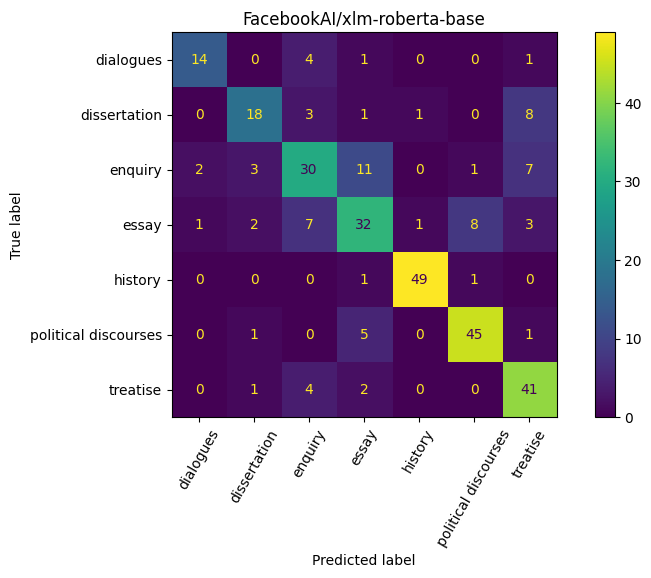

In [90]:
run_model('FacebookAI/xlm-roberta-base', data, n_epochs=10)

In [91]:
run_many('FacebookAI/xlm-roberta-base', n=15, n_epochs=10)

  0%|          | 0/15 [00:00<?, ?it/s]

Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.586600,1.083743,0.614887
2,0.984500,0.763240,0.705502
3,0.689400,0.657066,0.779935
4,0.477200,0.672631,0.773463
5,0.332400,0.609068,0.809061
6,0.210200,0.674114,0.799353
7,0.135100,0.771580,0.786408
8,0.079800,0.833140,0.799353
9,0.051900,0.840690,0.809061
10,0.035200,0.853246,0.805825


TEST ACCURACY:  0.832258064516129


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.497400,1.186544,0.524272
2,0.937000,0.846600,0.647249
3,0.641000,0.763038,0.724919
4,0.429500,0.663583,0.770227
5,0.311000,0.761083,0.773463
6,0.198500,0.938272,0.734628
7,0.134900,0.788217,0.799353
8,0.080600,0.940421,0.786408
9,0.054500,0.976703,0.796117
10,0.039500,0.968684,0.792880


TEST ACCURACY:  0.7709677419354839


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.466100,0.974860,0.644013
2,0.938900,0.832816,0.686084
3,0.678600,0.729388,0.731392
4,0.459400,0.749198,0.741100
5,0.313100,0.744800,0.766990
6,0.210800,0.736638,0.766990
7,0.130200,0.882005,0.786408
8,0.069800,0.858140,0.770227
9,0.053200,0.926515,0.792880
10,0.030200,0.940630,0.783172


TEST ACCURACY:  0.7451612903225806


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.515400,1.032838,0.608414
2,0.965400,0.849240,0.695793
3,0.698300,0.743588,0.734628
4,0.495200,0.723611,0.757282
5,0.313100,0.684765,0.766990
6,0.197300,0.717102,0.779935
7,0.135000,0.766279,0.786408
8,0.081200,0.812185,0.815534
9,0.057600,0.861452,0.789644
10,0.041700,0.885422,0.786408


TEST ACCURACY:  0.7709677419354839


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.468900,1.069204,0.605178
2,0.955400,0.759572,0.695793
3,0.692100,0.616751,0.779935
4,0.498000,0.600471,0.796117
5,0.354600,0.516223,0.818770
6,0.237900,0.573784,0.825243
7,0.151600,0.590423,0.822006
8,0.092600,0.667566,0.812298
9,0.060700,0.693557,0.828479
10,0.043500,0.711520,0.828479


TEST ACCURACY:  0.7580645161290323


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.447500,1.112616,0.576052
2,0.895700,0.766920,0.705502
3,0.645100,0.595665,0.786408
4,0.434300,0.537348,0.812298
5,0.277700,0.536761,0.815534
6,0.194400,0.548011,0.841424
7,0.114400,0.599673,0.834951
8,0.062200,0.666902,0.838188
9,0.048000,0.661404,0.857605
10,0.029200,0.664942,0.851133


TEST ACCURACY:  0.8032258064516129


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.551700,1.178396,0.475728
2,0.943800,0.840926,0.679612
3,0.650700,0.747309,0.734628
4,0.439700,0.872995,0.721683
5,0.290800,0.880030,0.741100
6,0.192300,0.913882,0.757282
7,0.123400,0.986543,0.757282
8,0.064100,1.125542,0.747573
9,0.047000,1.146627,0.766990
10,0.035300,1.157415,0.763754


TEST ACCURACY:  0.7645161290322581


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.466100,1.120958,0.511327
2,0.933800,0.933776,0.650485
3,0.656600,0.740643,0.747573
4,0.459800,0.723550,0.757282
5,0.289800,0.743834,0.776699
6,0.189600,0.871336,0.760518
7,0.107900,0.909607,0.779935
8,0.065500,0.949369,0.786408
9,0.046000,1.024151,0.802589
10,0.031400,1.039300,0.809061


TEST ACCURACY:  0.7709677419354839


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.491400,1.049726,0.624595
2,0.926600,0.755656,0.724919
3,0.659500,0.703629,0.737864
4,0.460300,0.639376,0.757282
5,0.300900,0.709174,0.766990
6,0.197700,0.648415,0.799353
7,0.129100,0.692379,0.815534
8,0.070600,0.769029,0.786408
9,0.048000,0.809398,0.802589
10,0.032300,0.764094,0.812298


TEST ACCURACY:  0.7741935483870968


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.475200,0.988932,0.637540
2,0.944800,0.810232,0.699029
3,0.656900,0.793910,0.715210
4,0.456900,0.775540,0.734628
5,0.312600,0.782980,0.763754
6,0.189000,0.858485,0.744337
7,0.121900,0.914774,0.766990
8,0.078900,1.002000,0.754045
9,0.049500,1.113425,0.757282
10,0.036400,1.100426,0.763754


TEST ACCURACY:  0.7387096774193549


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.462600,1.044160,0.611650
2,0.939100,0.754526,0.724919
3,0.645200,0.670721,0.763754
4,0.435800,0.695185,0.773463
5,0.295700,0.576708,0.828479
6,0.182000,0.655635,0.841424
7,0.103000,0.682040,0.828479
8,0.061700,0.693341,0.828479
9,0.035300,0.693989,0.834951
10,0.025400,0.736266,0.822006


TEST ACCURACY:  0.7806451612903226


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.458100,0.985716,0.572816
2,0.922000,0.769509,0.692557
3,0.654600,0.685048,0.747573
4,0.445800,0.690974,0.750809
5,0.291200,0.779104,0.766990
6,0.181200,0.766923,0.776699
7,0.112300,0.827875,0.773463
8,0.074400,0.875040,0.779935
9,0.054400,0.885627,0.789644
10,0.034600,0.853386,0.802589


TEST ACCURACY:  0.7838709677419354


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.441800,1.034229,0.598706
2,0.914900,0.801941,0.682848
3,0.677400,0.725209,0.731392
4,0.464800,0.738907,0.754045
5,0.302900,0.710851,0.754045
6,0.210400,0.732884,0.757282
7,0.137300,0.832167,0.773463
8,0.079200,0.921184,0.757282
9,0.053500,0.931301,0.763754
10,0.034300,0.951327,0.786408


TEST ACCURACY:  0.8129032258064516


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.464000,1.041501,0.601942
2,0.971700,0.775680,0.708738
3,0.645600,0.768520,0.724919
4,0.443400,0.655117,0.766990
5,0.282900,0.666274,0.789644
6,0.178000,0.645483,0.818770
7,0.104800,0.709678,0.812298
8,0.069000,0.793729,0.818770
9,0.041100,0.768718,0.822006
10,0.023700,0.792595,0.828479


TEST ACCURACY:  0.7774193548387097


Map:   0%|          | 0/2476 [00:00<?, ? examples/s]

Map:   0%|          | 0/309 [00:00<?, ? examples/s]

Map:   0%|          | 0/310 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,1.475000,0.975753,0.595469
2,0.927900,0.818462,0.711974
3,0.644400,0.701000,0.734628
4,0.446000,0.787273,0.741100
5,0.300900,0.817056,0.760518
6,0.187700,0.871167,0.779935
7,0.126800,0.937247,0.779935
8,0.076100,0.956851,0.773463
9,0.053100,1.023772,0.779935
10,0.037300,1.031150,0.770227


TEST ACCURACY:  0.7483870967741936
Mean accuracy:  0.7754838709677419
Standard deviation for accuracy:  0.02447648180677082
